# Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
import getpass  # To get the password without showing the input
from sqlalchemy import create_engine, text

Connect to MySQL

In [2]:
password = getpass.getpass()
user = 'root'
database_name = 'ab_test'
connection_string = f'mysql+pymysql://{user}:' + password + '@localhost/' + database_name
engine = create_engine(connection_string)

# Hypotesis 1:
Hypothesis on Client Tenure:

    Null Hypothesis (H0): The average client tenure (how long they’ve been with Vanguard) of those engaging with the new process is the same as those engaging with the old process.
    
    Alternative Hypothesis (H1): The average client tenure of those engaging with the new process is different from those engaging with the old process.

Get the data from MySQL

In [12]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT client_id, clnt_tenure_yr, clnt_tenure_mnth
            FROM df_final_demo;'''
    query = text(txt)
    result = connection.execute(query)
    data_demo = pd.DataFrame(result.all())

data_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth
0,169,21,262
1,555,3,46
2,647,12,151
3,722,11,143
4,934,9,109
...,...,...,...
70587,9999400,7,86
70588,9999626,9,113
70589,9999729,10,124
70590,9999832,23,281


In [21]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_experiment_clients
    txt = '''SELECT *
            FROM df_final_experiment_clients'''
    query = text(txt)
    result = connection.execute(query)
    data_client = pd.DataFrame(result.all())

data_client

,client_id,variation
0,169,None
1,555,Test
2,647,Test
3,722,None
4,934,Test
...,...,...
70587,9999400,Test
70588,9999626,Test
70589,9999729,Test
70590,9999832,Test


In [19]:
with engine.connect() as connection:
    # Combine data from both tables based on the client_id column.
    txt = '''SELECT d.client_id, d.clnt_tenure_yr, d.clnt_tenure_mnth, e.variation
            FROM df_final_demo d
            JOIN df_final_experiment_clients e ON d.client_id = e.client_id;'''
    query = text(txt)
    result = connection.execute(query)
    data_joined = pd.DataFrame(result.all())

data_joined

,client_id,clnt_tenure_yr,clnt_tenure_mnth,variation
0,169,21,262,None
1,555,3,46,Test
2,647,12,151,Test
3,722,11,143,None
4,934,9,109,Test
...,...,...,...,...
70587,9999400,7,86,Test
70588,9999626,9,113,Test
70589,9999729,10,124,Test
70590,9999832,23,281,Test


Statistic Analysis

In [22]:
# Combine data from df_final_demo and df_final_experiment_clients and verify if the Query is working right
combined_data = pd.merge(data_demo, data_client, on='client_id')
combined_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,variation
0,169,21,262,None
1,555,3,46,Test
2,647,12,151,Test
3,722,11,143,None
4,934,9,109,Test
...,...,...,...,...
70587,9999400,7,86,Test
70588,9999626,9,113,Test
70589,9999729,10,124,Test
70590,9999832,23,281,Test


*Note: The data is the same*

Plot the combined data

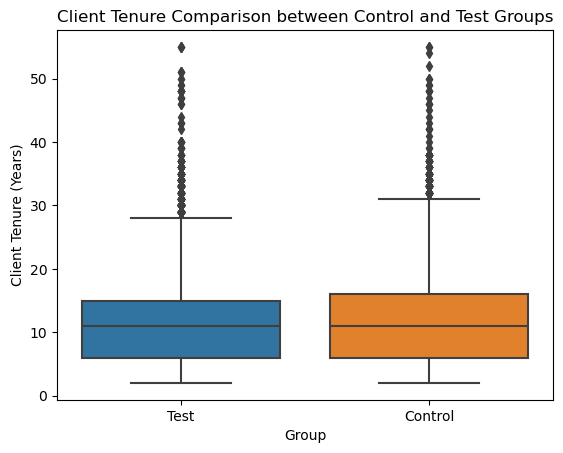

In [31]:
# Create a box plot
sns.boxplot(x='variation', y='clnt_tenure_yr', data=combined_data)
plt.title('Client Tenure Comparison between Control and Test Groups')
plt.xlabel('Group')
plt.ylabel('Client Tenure (Years)')
plt.show()

Separate data for control (old process) and test (new process) groups

In [25]:
with engine.connect() as connection:
    # Take the test group data only
    txt = '''SELECT df.client_id, df.clnt_tenure_yr, df.clnt_tenure_mnth, ec.variation
            FROM df_final_demo df
            JOIN df_final_experiment_clients ec ON df.client_id = ec.client_id
            WHERE ec.variation = 'control';'''
    query = text(txt)
    result = connection.execute(query)
    control_data = pd.DataFrame(result.all())

control_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,variation
0,1028,12,145,Control
1,1104,5,66,Control
2,1186,8,99,Control
3,1195,21,262,Control
4,1197,7,85,Control
...,...,...,...,...
23522,9997125,5,70,Control
23523,9997391,4,52,Control
23524,9997470,6,82,Control
23525,9998346,50,602,Control


In [26]:
with engine.connect() as connection:
    # Take the test group data only
    txt = '''SELECT df.client_id, df.clnt_tenure_yr, df.clnt_tenure_mnth, ec.variation
            FROM df_final_demo df
            JOIN df_final_experiment_clients ec ON df.client_id = ec.client_id
            WHERE ec.variation = 'test';'''
    query = text(txt)
    result = connection.execute(query)
    test_data = pd.DataFrame(result.all())

test_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,variation
0,555,3,46,Test
1,647,12,151,Test
2,934,9,109,Test
3,1336,48,576,Test
4,1346,14,177,Test
...,...,...,...,...
26954,9999150,5,66,Test
26955,9999400,7,86,Test
26956,9999626,9,113,Test
26957,9999729,10,124,Test


*Need to verify why this is not working*

In [23]:
# Separate data for control (old process) and test (new process) groups
control_data = combined_data[combined_data['variation'] == 'control']
test_data = combined_data[combined_data['variation'] == 'test']

print(f'Test Group: {test_data}')
print(f'Control Group: {control_data}')

Test Group: Empty DataFrame
Columns: [client_id, clnt_tenure_yr, clnt_tenure_mnth, variation]
Index: []
Control Group: Empty DataFrame
Columns: [client_id, clnt_tenure_yr, clnt_tenure_mnth, variation]
Index: []


In [27]:
# Perform t-test for comparing means
t_stat, p_value = ttest_ind(control_data['clnt_tenure_yr'], test_data['clnt_tenure_yr'])

print(f'Statistic: {t_stat}')
print(f'P-Value: {p_value}')

Statistic: 1.7096153693381262
P-Value: 0.08734316699459853


In [28]:
# Analyze the p-value to make a decision about the null hypothesis
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in client tenure.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in client tenure.")

Fail to reject the null hypothesis. There is no significant difference in client tenure.


# Hypotesis 2:
Hypothesis on Client Tenure-Related Completion Rate:

    Null Hypothesis (H0): Client tenure does not significantly impact the completion rate for the new design.
    
    Alternative Hypothesis (H1): Client tenure significantly impacts the completion rate for the new design.

Get the data from MySQL

In [3]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT *
            FROM df_final_demo;'''
    query = text(txt)
    result = connection.execute(query)
    data_demo = pd.DataFrame(result.all())

data_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gender,num_accts,balance,calls_6_mnth,logons_6_mnth
0,169,21,262,47,M,2,501571.0,4,4
1,555,3,46,29,U,2,25454.7,2,6
2,647,12,151,57,M,2,30525.8,0,4
3,722,11,143,59,F,2,22466.2,1,1
4,934,9,109,51,F,2,32522.9,0,3
...,...,...,...,...,...,...,...,...,...
70587,9999400,7,86,28,U,2,51787.0,0,3
70588,9999626,9,113,35,M,2,36642.9,6,9
70589,9999729,10,124,31,F,3,107060.0,6,9
70590,9999832,23,281,49,F,2,431888.0,1,4


In [4]:
with engine.connect() as connection:
    # Query to extract relevant columns from df_final_demo
    txt = '''SELECT *
            FROM df_final_web_data;'''
    query = text(txt)
    result = connection.execute(query)
    data_web = pd.DataFrame(result.all())

data_web

,id,client_id,visitor_id,visit_id,process_step,date_time
0,0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...,...
443765,744613,9895983,473024645_56027518531,498981662_93503779869_272484,step_3,2017-06-15 19:52:09
443766,744614,9895983,473024645_56027518531,498981662_93503779869_272484,step_2,2017-06-15 19:50:37
443767,744615,9895983,473024645_56027518531,498981662_93503779869_272484,step_1,2017-06-15 19:50:05
443768,744616,9895983,473024645_56027518531,498981662_93503779869_272484,start,2017-06-15 19:50:00


In [5]:
with engine.connect() as connection:
    # Combine data from both tables based on the client_id column.
    txt = '''SELECT *
            FROM df_final_demo
            JOIN df_final_web_data ON df_final_demo.client_id = df_final_web_data.client_id;'''
    query = text(txt)
    result = connection.execute(query)
    data_joined = pd.DataFrame(result.all())

data_joined

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gender,num_accts,balance,calls_6_mnth,logons_6_mnth,id,client_id,visitor_id,visit_id,process_step,date_time
0,169,21,262,47,M,2,501571.0,4,4,283819,169,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09
1,169,21,262,47,M,2,501571.0,4,4,283820,169,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05
2,169,21,262,47,M,2,501571.0,4,4,283821,169,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31
3,169,21,262,47,M,2,501571.0,4,4,283822,169,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45
4,169,21,262,47,M,2,501571.0,4,4,283823,169,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443765,9999839,13,160,28,F,2,67425.4,3,3,272811,9999839,948322592_28990736246,715530422_68620416793_515645,step_3,2017-03-29 12:12:28
443766,9999839,13,160,28,F,2,67425.4,3,3,272812,9999839,948322592_28990736246,715530422_68620416793_515645,step_2,2017-03-29 12:11:50
443767,9999839,13,160,28,F,2,67425.4,3,3,272813,9999839,948322592_28990736246,715530422_68620416793_515645,step_1,2017-03-29 12:11:35
443768,9999839,13,160,28,F,2,67425.4,3,3,272814,9999839,948322592_28990736246,715530422_68620416793_515645,start,2017-03-29 12:11:32


Statistic Analysis

In [6]:
# Combine data from df_final_demo and df_final_web_data and verify if the Query is working right
combined_data = pd.merge(data_demo, data_web, on='client_id')
combined_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gender,num_accts,balance,calls_6_mnth,logons_6_mnth,id,visitor_id,visit_id,process_step,date_time
0,169,21,262,47,M,2,501571.0,4,4,283819,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09
1,169,21,262,47,M,2,501571.0,4,4,283820,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05
2,169,21,262,47,M,2,501571.0,4,4,283821,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31
3,169,21,262,47,M,2,501571.0,4,4,283822,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45
4,169,21,262,47,M,2,501571.0,4,4,283823,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443765,9999839,13,160,28,F,2,67425.4,3,3,272811,948322592_28990736246,715530422_68620416793_515645,step_3,2017-03-29 12:12:28
443766,9999839,13,160,28,F,2,67425.4,3,3,272812,948322592_28990736246,715530422_68620416793_515645,step_2,2017-03-29 12:11:50
443767,9999839,13,160,28,F,2,67425.4,3,3,272813,948322592_28990736246,715530422_68620416793_515645,step_1,2017-03-29 12:11:35
443768,9999839,13,160,28,F,2,67425.4,3,3,272814,948322592_28990736246,715530422_68620416793_515645,start,2017-03-29 12:11:32


*Note: The data is the same*

Plot the combined data

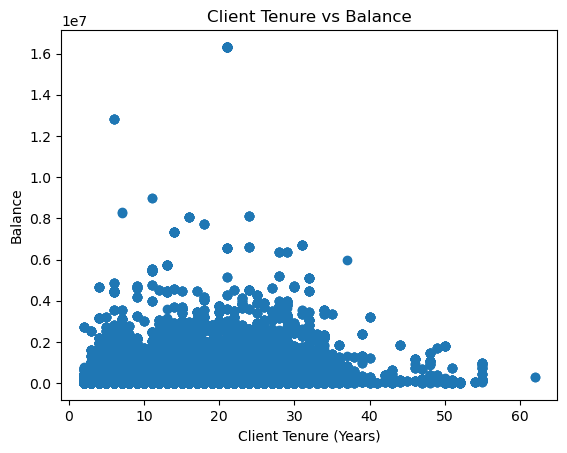

In [13]:
# Scatter plot
plt.scatter(x= 'clnt_tenure_yr', y= 'balance', data= combined_data)
plt.xlabel('Client Tenure (Years)')
plt.ylabel('Balance')
plt.title('Client Tenure vs Balance')
plt.show()

In [11]:
with engine.connect() as connection:
    # Combine data from both tables based on the client_id column.
    txt = '''SELECT *
            FROM df_final_demo
            JOIN df_final_web_data ON df_final_demo.client_id = df_final_web_data.client_id
            WHERE process_step = 'completed';'''
    query = text(txt)
    result = connection.execute(query)
    completed_data = pd.DataFrame(result.all())

completed_data

""


In [8]:
# Assuming 'process_step' is the column indicating completion of a certain step
completed_data = combined_data[combined_data['process_step'] == 'completed']
completed_data

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gender,num_accts,balance,calls_6_mnth,logons_6_mnth,id,visitor_id,visit_id,process_step,date_time


Desing the crosstable

In [12]:
# Create a contingency table for chi-squared test
contingency_table = pd.crosstab(completed_data['clnt_tenure_yr'], completed_data['variation'])
contingency_table

KeyError: 'clnt_tenure_yr'

In [ ]:
# Perform chi-squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f'Statistic: {chi2_stat}')
print(f'P-Value: {p_value}')

In [ ]:
# Analyze the p-value to make a decision about the null hypothesis
if p_value < 0.05:
    print("Reject the null hypothesis. Client tenure significantly impacts completion rate.")
else:
    print("Fail to reject the null hypothesis. Client tenure does not significantly impact completion rate.")